In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Toy example:

Suppose that we have the following model

$z_n \sim Categorical(\pi)$

$x_n | z_n = k \sim N(\mu_k, \sigma_k)$

$y_n | z_n = k \sim Bernoulli(p_k)$

and suppose that we have learned the model parameters $\Theta = \{ \pi, \mu_k, \sigma_k, p_k \}$.

Having learned the parameters, given a test sample $x^*$ without the corresponding label $y^*$, we must make a decision---a hard assignment---of what $y^*$ might be. Associated with the decision is a cost, encoded as a loss function $L(\hat{y}, y)$, where $\hat{y}$ is the guess and $y$ the truth. For example, we might have:

$$L(\hat{y}, y)  = 
\begin{cases}
100 & \text{if } \hat{y} = 1, y = 0 \\
10  & \text{if } \hat{y} = 0, y = 1 \\
0   & \text{if } \hat{y} = y 
\end{cases}$$

In other words, there is a greater penalty to incorrectly guessting that $y = 0$. As a mnemonic guide, call $y = 0$ "green" and $y = 1$ "red". There is a higher penalty for guessing the light is green when it really is red. For general loss values, we denote $L_{10} = L_{RG}$ is the loss of guessing red when the truth is green, and $L_{01} = L_{GR}$ is defined similarly.

#### Baseline (the plugin estimator)
Given $x^*$, we may compute the posterior probability $p(y^*|x^*)$ as

$$\begin{align*}
p(y^*|x^*) &\propto \sum_{z^*} p(z^*|\pi) p(x^*|z^*) p(y^*|z^*) \\
&= p(z^* = 0|\pi) p(x^*|z^* = 0) p(y^*|z^* = 0 ) + p(z^* = 1|\pi) p(x^*|z^* = 1) p(y^*|z^* = 1) \\
&= \pi_0 N(x^* | \mu_0, \sigma_0) Bernoulli(y^*|p_0) + \pi_1 N(x^* | \mu_1, \sigma_1) Bernoulli(y^*|p_1)
\end{align*}$$

And we will choose as our decision $\hat{y}$ whichever value of $y$ has the higher posterior probability. That is,

$$\hat{y} = \text{argmax}_{y^*} \; p(y^*|x^*) $$

#### The decision aware way 
Rather than the above decision, we may choose whichever value of $y$ that minimizes the expected loss, or, equivalently, maximizes the expected utility $U(y,y^*)$ with respect to the posterior $p(y^*|x^*)$. In the discussion below, we will frame the problem as maximization with respect to the utility 

$$
\begin{align*}
\hat{y} &= \text{argmax}_{y} \; \sum_{y*} U(y, y^*) p(y^*|x^*) \\
&= \text{argmax}_{y} \; [ U(y, R) p(R|x^*) + U(y, G) p(G|x^*) ]
\end{align*}
$$ 

where $p(R|x^*)$ means $p(y^* = R|x^*)$. We simply plug in for $y \in \{ G, R \}$ and compare the expected costs of the decisions, using the general loss values:

Decision $y = G$: 

$$
\begin{align*}
U(y=G, R) p(R|x^*) + U(y=G, G) p(G|x^*) &= -L_{GR} * p(R|x^*) - L_{GG} * p(G|x^*)
\end{align*}
$$

where $p_0$ is the Bernoulli parameter of the $z=0$ component and thus the probability of $y = 1$ or $y = Red$ given $z=0$.

Similarly the expected cost of the decision $y = R$ is

$$
\begin{align*}
U(y=R, R) p(R|x^*) + U(y=R, G) p(G|x^*) &= -L_{RR} * p(R|x^*) + -L_{RG} * p(G|x^*)
\end{align*}
$$

Setting the expected costs of the decisions equals to each other gives us the decision bound as a function of $x^*$; we choose $\hat{y} = G$ if

$$
\frac{p(G|x^*)}{p(R|x^*)} \geq \frac{U_{RR} - U_{GR}}{U_{GG} - U_{RG}}
$$

For this thereshold to be meaningful (i.e. the decision depends on the probability $p(y^*|x^*)$), we might require that $U_{RR} > U_{GR}$ and $U_{GG} > U_{RG}$, such that the threshold $\frac{U_{RR} - U_{GR}}{U_{GG} - U_{RG}} > 0$. Any sensible utility function should satisfy this criterion, however, as it merely states that the utility of guessing correctly is greater than that of getting it wrong.

The optimal decision $h$ is then 

$$
h(x^*) =
\begin{cases}
G & \text{if } D(x^*) \geq T \\
R & \text{otherwise}
\end{cases}
$$

where $D(x^*) = \frac{p(G|x^*)}{p(R|x^*)}$ and $T = \frac{U_{RR} - U_{GR}}{U_{GG} - U_{RG}}$. $T$ is a threshold determined soley by the utility function, and $D(x^*)$ is the probabilistic quantity that depends on the observed test data $x^*$.

Let's interpret this result. The threshold $T$ captures the ratio of releative distance between potential actions given the true state.

For example, we might set $U_{RR} = U_{GG} = 101$---we're happy to when we make the correction decision. $U_{RG} = 51$ seems reasonable, as stopping at the light when it's green isn't ideal but we're safe. $U_{GR} = 1$ is reasonable for the risky behavior of running a red light. The threshold then equals $T = 2$---we require that the probability of the green light is twice more likely than the probability of a red light.

#### Example

Suppose that if $z = 0$, the probability of red $p_0 = 0.75$, and the corresponding probability of red for $z = 1$ is $p_1 = 0.5$. In other words, if $z = 0$, we are fairly confident that the light is red, whereas we have no information if $z = 1$.

In [9]:
# Generate Data 
# negative label = 0 (green),  positive label = 1 (red)

def generate_data_from_paper(flipped=False):
    # (see 3.2 Toy Example: Why Asymmetry Matters in https://arxiv.org/pdf/1707.07341.pdf )

    # "interval A contains 175 data points x \in [−1, 1], with a roughly even distribution of positive and negative labels"
    x_A = np.random.uniform(-1, 1, 175)
    y_A = np.random.binomial(1, 0.5, 175)

    # interval B contains 100 points x \in [1, 1.5] with purely positive labels
    # (or, if flipped=True, purely negative (green) labels)
    x_B = np.random.uniform(1, 1.5, 100)
    lab = 0 if flipped else 1
    y_B = np.repeat(lab, 100)

    # interval C contains 75 points x ∈ [1.5, 2.0] with purely negative labels 
    x_C = np.random.uniform(1.5, 2.0, 75)
    lab = 1 if flipped else 0
    y_C = np.repeat(lab, 75)

    x = np.concatenate((x_A, x_B, x_C))
    y = np.concatenate((y_A, y_B, y_C))
    
    return x,y
x,y = generate_data_from_paper(True)

Text(0.5, 1.0, 'Data with the learned Gaussian mixture overlaid')

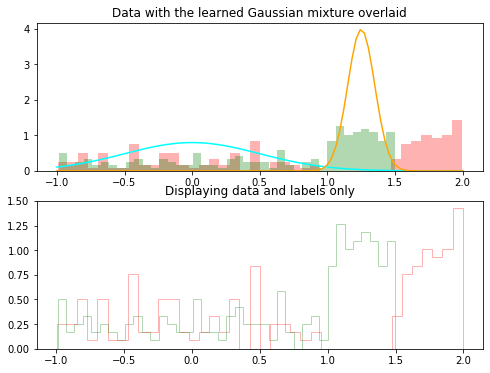

In [11]:
# plot this!
# using the variable axs for multiple Axes
fig, ax = plt.subplots(2)
fig.set_size_inches(8,6)

### can filter using np.extract(), perhaps
red_indices = y == 1
green_indices = y == 0
x_red = np.extract(red_indices, x)
x_green = np.extract(green_indices, x)

### histogram first
ax[0].hist(x_red, color="red", histtype='stepfilled', density=True, alpha = 0.3, bins=40)
ax[0].hist(x_green, color="green", histtype='stepfilled', density=True, alpha = 0.3, bins=40)

ax[1].hist(x_red, color="red", density=True, alpha = 0.3, bins=40, histtype='step')
ax[1].hist(x_green, color="green", density=True, alpha = 0.3, bins=40, histtype='step')
ax[1].set_title("Displaying data and labels only")

### overlay the gaussians
def get_parameters(flipped=False):
    # z|\pi ~ Categorical(\pi)
    # y|z_k ~ Bernoulli(p_k) Given the comonent, probability of 1 = red
    # x_n|z_n ~ N()
    pi = np.array([0.5, 0.5]) # the mixture components are equally likely
    p = np.array([0.5, 0.01]) if flipped else np.array([0.3, 0.7]) # when we're in the z = 1 cluster, we're more confident that the light is red
    mu = np.array([0.0, 1.25]) # the centers of the Gaussian mixtures, taken from the plot
    sigma = np.array([0.5, 0.1]) # the spread of the clusters
    return pi, p, mu, sigma

pi, p, mu, sigma = get_parameters(True)

# Visualize the data and the learned parameters
x_grid = np.linspace(-1.0, 2.0, 100)
ax[0].plot(x_grid, norm.pdf(x_grid, mu[0], sigma[0]), color="cyan")
ax[0].plot(x_grid, norm.pdf(x_grid, mu[1], sigma[1]), color="orange")
ax[0].set_title("Data with the learned Gaussian mixture overlaid")

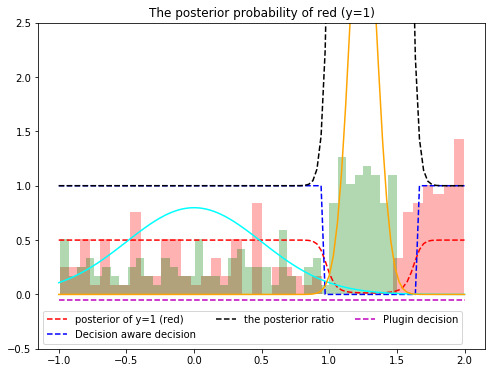

In [12]:
### The plugin-estimator way
def get_posterior(x_test):
    ''' Given a test point, return the posterior probability of y = 1 (red)'''
    # Then compute the unnormalized prob of y=0
    unnormalized_posterior_of_y0 = 0.0
    for z in np.arange(2):
        # p(z)*p(x|z)*p(y|z)
        unnormalized_posterior_of_y0 += pi[z] * norm.pdf(x_test, mu[z], sigma[z]) * (1.0-p[z])
        
    # Then compute the unnormalized prob of y=1
    unnormalized_posterior_of_y1 = 0.0
    for z in np.arange(2):
        # p(z)*p(x|z)*p(y|z)
        unnormalized_posterior_of_y1 += pi[z] * norm.pdf(x_test, mu[z], sigma[z]) * p[z]
    
    normalization = unnormalized_posterior_of_y0 + unnormalized_posterior_of_y1
    return unnormalized_posterior_of_y1/normalization

x_test = np.linspace(-1, 2, 100)
y_post = get_posterior(x_test)

plugin_decision = np.argmax(np.column_stack((1.0-y_post, y_post)), axis=1)

### The decision aware way: now what would this be.
# U_xy is the utility of guessing x when it really is y
U_rr = 101.0
U_gr = 1.0
U_gg = 101.0
U_rg = 51.0
threshold = (U_rr - U_gr)/(U_gg - U_rg)

# The deicision function depends on the ratio P(y=0|x*)/P(y=1|x*)
# if the above ratio is less than the threshold, the decision is red
odds_ratio = (1.0 - get_posterior(x_test))/get_posterior(x_test)
decision = odds_ratio < threshold

fig = plt.figure()
ax = plt.axes()
fig.set_size_inches(8,6)
ax.plot(x_test, y_post, "--r", label="posterior of y=1 (red)")
ax.set_title("The posterior probability of red (y=1)")
ax.plot(x_test, decision.astype(int), '--b', label="Decision aware decision")
ax.plot(x_test, odds_ratio, '--k', label="the posterior ratio")
ax.plot(x_test, plugin_decision -0.05, '--m', label="Plugin decision") # -0.05 to make the line visible
ax.legend(ncol = 3)
ax.set_ylim(-0.5, 2.5)

# copied and pasted from above--not ideal
ax.hist(x_red, color="red", histtype='stepfilled', density=True, alpha = 0.3, bins=40)
ax.hist(x_green, color="green", histtype='stepfilled', density=True, alpha = 0.3, bins=40)
ax.plot(x_grid, norm.pdf(x_grid, mu[0], sigma[0]), color="cyan")
ax.plot(x_grid, norm.pdf(x_grid, mu[1], sigma[1]), color="orange")

# Start here: the plot looks decent but it's not right. The posterior of y = 1 should increase in the red zone, I think. 
# Further, the decision-aware decision should be 0 through out and 1...hmmmm. Need to be careful. Anyway good stuff.    

So in this particular example, we always choose $y = 1$ (red). We're particularly confident near $x=1.25$, where the peak of the Gaussian confident Gaussian component resides. The decision made isn't nuanced at all, for example we don't adopt strategies like, go when we're absolutely sure the light is green. Otherwise, stop.

I think we can vary this example to be something like, in some areas, the chances of green is 80%. The other cases, we have no idea---in this scenario we want it to stop, not flip a coin.

Like we can say that this is a self-driving car, and the way light hits the traffic light makes it difficult to decide what is what, also the weather.

As one can see, the decisions are fairly comparable. 
* How can we measure that one is better than the other?
* Generate a test sample from the same model, and compute the loss. Yes, that should be my next step.
* Try a different example---maybe that will give me a better insight/picture.

In [ ]:
### 